In [110]:
import sys
import os

path = os.getcwd()

from collections import Counter

import matplotlib
import matplotlib.pyplot as plt

import numpy as np

import pandas as pd

import scipy.stats

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.dummy import DummyClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, PowerTransformer, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import brier_score_loss, make_scorer
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.pipeline import Pipeline

matplotlib.rcParams.update({'xtick.labelsize': 16})
matplotlib.rcParams.update({'ytick.labelsize': 16})

In [40]:
# Read in the csv file
df = pd.read_csv(path + '/' + 'haberman.data.csv')

In [41]:
# Understand the layout of the dataframe
# AGE   == Age of patient at time of operation
# YEAR  == Patient's year of operation (year - 1900)
# NODES == Number of positive axillary nodes detected
# STATE == Survival status,
#     1 == Patient survived 5 years or longer
#     2 == Patient died within 5 years
df.head()


,AGE,YEAR,NODES,STATE
0,30,64,1,1
1,30,62,3,1
2,30,65,0,1
3,31,59,2,1
4,31,65,4,1


In [42]:
# Get statistics of the data set
df.describe()


,AGE,YEAR,NODES,STATE
count,306.000000,306.000000,306.000000,306.000000
mean,52.457516,62.852941,4.026144,1.264706
std,10.803452,3.249405,7.189654,0.441899
min,30.000000,58.000000,0.000000,1.000000
25%,44.000000,60.000000,0.000000,1.000000
50%,52.000000,63.000000,1.000000,1.000000
75%,60.750000,65.750000,4.000000,2.000000
max,83.000000,69.000000,52.000000,2.000000


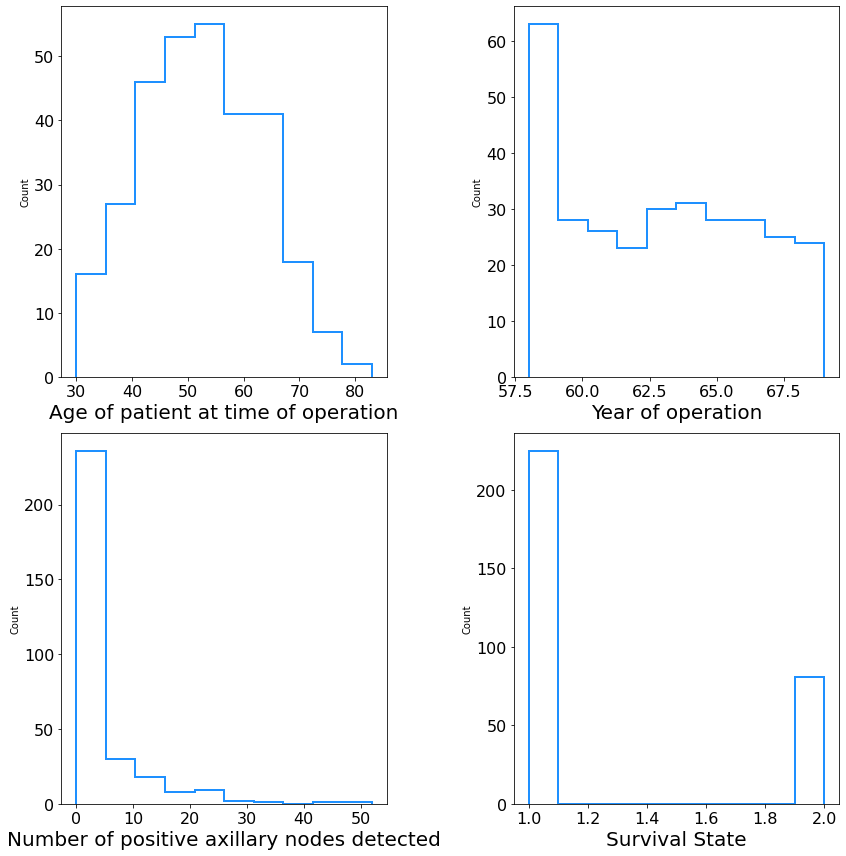

In [43]:
fig, ax = plt.subplots(2,2, figsize=(12,12))

ax[0,0].hist(df['AGE'], lw=2, histtype='step', color='dodgerblue')
ax[0,0].set_xlabel('Age of patient at time of operation',fontsize=20)
ax[0,0].set_ylabel('Count')

ax[0,1].hist(df['YEAR'], lw=2, histtype='step', color='dodgerblue')
ax[0,1].set_xlabel('Year of operation',fontsize=20)
ax[0,1].set_ylabel('Count')

ax[1,0].hist(df['NODES'], lw=2, histtype='step', color='dodgerblue')
ax[1,0].set_xlabel('Number of positive axillary nodes detected',fontsize=20)
ax[1,0].set_ylabel('Count')

ax[1,1].hist(df['STATE'], lw=2, histtype='step', color='dodgerblue')
ax[1,1].set_xlabel('Survival State',fontsize=20)
ax[1,1].set_ylabel('Count')

plt.tight_layout()

plt.savefig(path + '/' + 'haberman_hist.pdf')


In [82]:
tar = df['STATE'].values
ct = Counter(tar)
for k,v in ct.items():
    per = v / len(tar) * 100.0
    print('Class={0:d}, Count={1:d}, Percentage={2:.1f}'.format(k, v, per))
    if k == 2:
        per_pos = per/100.0
    

Class=1, Count=225, Percentage=73.5
Class=2, Count=81, Percentage=26.5


In [83]:
data = df.values

# split into input and output elements
X, y = data[:, :-1], data[:, -1]

# label encode the target variable to have the classes 0 and 1
y = LabelEncoder().fit_transform(y)


In [84]:
# calculate brier skill score (BSS)
def brier_skill_score(y_true, y_prob):
    # calculate reference brier score
    ref_probs = [per_pos for _ in range(len(y_true))]
    bs_ref = brier_score_loss(y_true, ref_probs)
    # calculate model brier score
    bs_model = brier_score_loss(y_true, y_prob)
    # calculate skill score
    print(1.0 - (bs_model / bs_ref))
    return 1.0 - (bs_model / bs_ref)


In [85]:
# evaluate a model
def evaluate_model(X, y, model):
    # define evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # define the model evaluation the metric
    metric = make_scorer(brier_skill_score, needs_proba=True)
    # evaluate model
    scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
    return scores


In [86]:
# summarize the loaded dataset
print(X.shape, y.shape, Counter(y))


(306, 3) (306,) Counter({0: 225, 1: 81})


In [87]:
# define the reference model
model = DummyClassifier(strategy='prior')


In [88]:
# evaluate the model
scores = evaluate_model(X, y, model)
# summarize performance
print('Mean BSS: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))


Mean BSS: -0.000 (0.000)


In [91]:
# define models
models = [LogisticRegression(solver='lbfgs'), LinearDiscriminantAnalysis(),
          QuadraticDiscriminantAnalysis(), GaussianNB(), MultinomialNB(),
          GaussianProcessClassifier()]


In [98]:
names, values = list(), list()
# evaluate each model
for model in models:
    # get a name for the model
    name = type(model).__name__[:6]
    # evaluate the model and store results
    scores = evaluate_model(X, y, model)
    # summarize and store
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
    names.append(name)
    values.append(scores)
    

>Logist 0.060 (0.143)
>Linear 0.064 (0.154)
>Quadra 0.027 (0.221)
>Gaussi 0.012 (0.212)
>Multin -0.211 (0.369)
>Gaussi -0.142 (0.041)


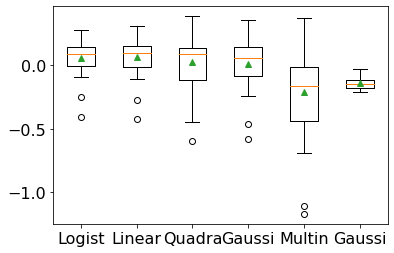

In [99]:
# plot the results
plt.boxplot(values, labels=names, showmeans=True)
plt.show()


In [102]:
# create a pipeline
pip = Pipeline(steps=[('t', StandardScaler()),('m',model)])
# evaluate the model and store results
scores = evaluate_model(X, y, pip)


In [103]:
# define models
models = [LogisticRegression(solver='lbfgs'), LinearDiscriminantAnalysis(),
          QuadraticDiscriminantAnalysis(), GaussianNB(), GaussianProcessClassifier()]


In [105]:
names, values = list(), list()
# evaluate each model
for model in models:
    # get a name for the model
    name = type(model).__name__[:7]
    # create a pipeline
    pip = Pipeline(steps=[('t', StandardScaler()),('m',model)])
    # evaluate the model and store results
    scores = evaluate_model(X, y, pip)
    # summarize and store
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
    names.append(name)
    values.append(scores)
    

>Logisti 0.062 (0.140)
>LinearD 0.064 (0.154)
>Quadrat 0.027 (0.221)
>Gaussia 0.012 (0.212)
>Gaussia 0.097 (0.133)


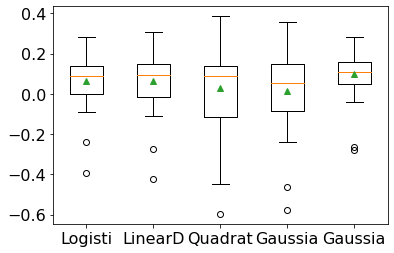

In [106]:
# plot the results
plt.boxplot(values, labels=names, showmeans=True)
plt.show()


In [111]:
# create a pipeline
pip = Pipeline(steps=[('t1', MinMaxScaler()), ('t2', PowerTransformer()),('m',model)])
# evaluate the model and store results
scores = evaluate_model(X, y, pip)


In [112]:
models = [LogisticRegression(solver='lbfgs'), LinearDiscriminantAnalysis(), GaussianProcessClassifier()]


In [113]:
names, values = list(), list()
# evaluate each model
for model in models:
    # get a name for the model
    name = type(model).__name__[:7]
    # create a pipeline
    pip = Pipeline(steps=[('t1', MinMaxScaler()), ('t2', PowerTransformer()),('m',model)])
    # evaluate the model and store results
    scores = evaluate_model(X, y, pip)
    # summarize and store
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
    names.append(name)
    values.append(scores)
    

>Logisti 0.110 (0.142)
>LinearD 0.107 (0.164)
>Gaussia 0.100 (0.130)


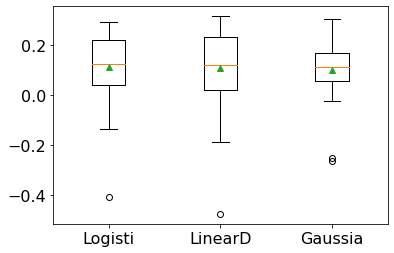

In [115]:
# plot the results
plt.boxplot(values, labels=names, showmeans=True)
plt.show()


In [116]:
# fit the model
model = Pipeline(steps=[('t1', MinMaxScaler()), ('t2', PowerTransformer()),('m',LogisticRegression(solver='lbfgs'))])
model.fit(X, y)


Pipeline(steps=[('t1', MinMaxScaler()), ('t2', PowerTransformer()),
                ('m', LogisticRegression())])

In [118]:
# some survival cases
print('Known Survival Cases:')
data = [[31,59,2], [31,65,4], [34,60,1]]
for row in data:
    # make prediction
    yhat = model.predict_proba([row])
    # get percentage of survival
    p_survive = yhat[0, 0] * 100
    # summarize
    print('>data=%s, Survival=%.3f%%' % (row, p_survive))
    

Survival Cases:
>data=[31, 59, 2], Survival=83.597%
>data=[31, 65, 4], Survival=77.264%
>data=[34, 60, 1], Survival=86.776%


In [119]:
# some non-survival cases
print('Known Non-Survival Cases:')
data = [[44,64,6], [34,66,9], [38,69,21]]
for row in data:
    # make prediction
    yhat = model.predict_proba([row])
    # get percentage of survival
    p_survive = yhat[0, 0] * 100
    # summarize
    print('data=%s, Survival=%.3f%%' % (row, p_survive))
    

Non-Survival Cases:
data=[44, 64, 6], Survival=63.092%
data=[34, 66, 9], Survival=63.452%
data=[38, 69, 21], Survival=53.389%


In [122]:
# some new cases
print('Test Cases:')
data = [[26,66,0], [26,66,5], [26,66,10]]
for row in data:
    # make prediction
    yhat = model.predict_proba([row])
    # get percentage of survival
    p_survive = yhat[0, 0] * 100
    # summarize
    print('data=%s, Survival=%.3f%%' % (row, p_survive))
    

Test Cases:
data=[26, 66, 0], Survival=93.095%
data=[26, 66, 5], Survival=77.119%
data=[26, 66, 10], Survival=67.479%
